In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df=pd.read_excel("covid_World_updated.xlsx")
df.date=pd.to_datetime(df.date,infer_datetime_format=True)
#United States,Brazil,World,India
location_name="World"
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


### Creating Data Frame with Total Cases lags

In [129]:
from fbprophet import Prophet

In [160]:
def accuracy(realSales_series, prediction_series):

    assert isinstance(realSales_series, pd.Series), 'Real Sales should be in pandas Series format'
    assert isinstance(prediction_series, pd.Series), 'Prediction should be in pandas Series format'
#     prediction_series=np.max(0,prediction_series)
    acc =round((1 - abs(prediction_series - realSales_series)/prediction_series) * 100,2)
    acc.loc[(realSales_series == 0) & (prediction_series != 0)] = 0
    acc.loc[(realSales_series == 0) & (prediction_series == 0)] = np.nan
    #acc.loc[acc > 95] = 100
    acc.loc[acc < 0] = 0
    acc.dropna()
    return acc

In [131]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [132]:
def forecasting(df_out,regressor,table,graph):
    
    df_out1=pd.DataFrame(columns=["ds","y"]) 
    
        
    df_out1['y']=df_out['Deaths']
    df_out1['ds']=df_out.index
    
    if regressor=="Confirmed":
        df_out1['ConLag14']=df_out['ConLag14']
#     elif regressor=="Cured":
#         df_out1['CurLag5']=df_out['CurLag5']
#     else:
#         df_out1['ConLag5']=df_out['ConLag5']
#         df_out1['CurLag5']=df_out['CurLag5']
        
        
    df_out1.reset_index(inplace=True,drop=True)
    
    #print(df_out1)
    
        
    model=Prophet(daily_seasonality=True,yearly_seasonality=False)
    
    if regressor=="Confirmed":
        model.add_regressor('ConLag14')
#     elif regressor=="Cured":
#         model.add_regressor('CurLag5')
#     else:
#         model.add_regressor('ConLag5')
#         model.add_regressor('CurLag5')
        
    #print(df_out)    
    model.fit(df_out1)
    
    future = model.make_future_dataframe(periods=14)
    
    if regressor=="Confirmed":
        conlag=list(df_out1['ConLag14'])
        for i in range(14,0,-1):
            conlag.append(list(df_location['total_cases'])[-i])
        #print(conlag)
            
        future['ConLag14']=list(conlag)
        #print(future.tail(14))
        #print(future)
#     elif regressor=="Cured":
#         curlag=list(df_out1['CurLag5'])
#         #curlag.append(list(df_State['Cured'])[-1])
#         for i in range(5,0,-1):
#             curlag.append(list(df_State['Cured'])[-i])

#         future['CurLag5']=list(curlag)
#     else:
#         conlag=list(df_out1['ConLag5'])
#         for i in range(5,0,-1):
#             conlag.append(list(df_State['Confirmed'])[-i])
#         #conlag.append(list(df_State['Confirmed'])[-1])
#         curlag=list(df_out1['CurLag5'])
#         for i in range(5,0,-1):
#             curlag.append(list(df_State['Cured'])[-i])
#         #curlag.append(list(df_State['Cured'])[-1])
#         future['ConLag5']=list(conlag)
#         future['CurLag5']=list(curlag)
#     #print(future)
    
    forecast=model.predict(future)
    if table=="Yes":
        print("Forecasted Table for number of Deaths for location: "+location_name+"\n")
        Forecast=pd.DataFrame()
        Forecast['Day']=forecast['ds']
        Forecast['Forecasted_Death']=[int(x) for x in list(forecast['yhat'])]
        Forecast['Lower Limit']=[int(x) for x in list(forecast['yhat_lower'])]
        Forecast['Upper Limit']=[int(x) for x in list(forecast['yhat_upper'])]
        Forecast.set_index('Day',inplace=True)
        print(Forecast.tail(14))
    return list(Forecast['Forecasted_Death'])[-1]

In [161]:
i=29
j=i-14
table="Yes"
graph="Yes"
regressor="Confirmed"
pred14=[]
while j>=0:
    df.index = pd.DatetimeIndex(df.date)
    df_location=df[df['location']==location_name]
    df_location=df_location[:-i]
    df_location['date']=df_location.index
    df_location.reset_index(inplace = True, drop = True)
    df_out={'Date': df_location.date.to_list(),
             'Deaths':df_location.total_deaths.to_list(),
            'ConLag14':df_location.total_cases.shift(14).to_list(),
           }
    df_out=pd.DataFrame(df_out)
    df_out.columns
    df_out=df_out.dropna()
    df_out.set_index('Date',inplace=True)
    for cols in df_out.columns:
        if cols=="Date":
            continue
        else:
            df_out[cols]=df_out[cols].astype(int)
            
    print('df_out')
    print(df_out)
            
    pred14.append(forecasting(df_out,regressor,table,graph))
    i=i-1
    j=j-1

df_out
            Deaths  ConLag14
Date                        
2020-01-14       1        27
2020-01-15       2        27
2020-01-16       2        27
2020-01-17       2        44
2020-01-18       2        44
...            ...       ...
2020-08-27  825948  20637051
2020-08-28  832030  20923721
2020-08-29  837487  21212639
2020-08-30  843184  21472272
2020-08-31  846957  21704633

[231 rows x 2 columns]
Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-09-01            855498       854357       856722
2020-09-02            861900       860679       863185
2020-09-03            868326       867054       869643
2020-09-04            874952       873566       876436
2020-09-05            881058       879425       882749
2020-09-06            886720       884806       888712
2020-09-07            891538       889115       893904
2020-09-08            896769       894

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-09-07            888930       887556       890372
2020-09-08            893971       892447       895405
2020-09-09            900225       898707       901655
2020-09-10            906477       904812       908222
2020-09-11            912898       911074       914722
2020-09-12            918966       916872       921103
2020-09-13            924608       922095       927222
2020-09-14            929405       926351       932195
2020-09-15            934285       930997       937808
2020-09-16            940469       936410       944501
2020-09-17            946688       941701       951536
2020-09-18            953133       947306       958650
2020-09-19            959113       953011       964640
2020-09-20            964699       957416       971102
df_out
            Deaths  ConLag14
Date                     

Forecasted Table for number of Deaths for location: World

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-09-14            928477       926924       930059
2020-09-15            933481       931975       935086
2020-09-16            939678       937977       941363
2020-09-17            945816       943965       947590
2020-09-18            952151       950154       953993
2020-09-19            958119       955889       960211
2020-09-20            963662       961205       966177
2020-09-21            968632       965775       971534
2020-09-22            973726       970181       977122
2020-09-23            979982       976108       983901
2020-09-24            986109       981742       991081
2020-09-25            992379       986784       998017
2020-09-26            998317       992240      1004415
2020-09-27           1003842       997226      1010809
df_out
            Deaths  ConLag14
Date                     

In [162]:
df_output=pd.DataFrame()
mape=[]
df_location=df[df['location']==location_name]
real=list(df_location.total_deaths[-16:])
for i in range(len(real)):
    mape.append(mean_absolute_percentage_error(real[i],pred14[i]))
score=accuracy(pd.Series(real),pd.Series(pred14))
df_output['Date']=list(df[df['location']==location_name].date[-16:])
df_output['Real']=real
df_output['Pred']=pred14
df_output['Accuracy']=score
df_output['Error%(MAPE)']=mape
#df_output.set_index(df_output.Date,inplace=True,drop=True)

In [163]:
df_output

,Date,Real,Pred,Accuracy,Error%(MAPE)
0,2020-09-14,924837.0,932837,99.14,0.865017
1,2020-09-15,929074.0,937105,99.14,0.864409
2,2020-09-16,936029.0,942790,99.28,0.722307
3,2020-09-17,941466.0,948552,99.25,0.752656
4,2020-09-18,946785.0,954333,99.21,0.797224
5,2020-09-19,952737.0,959705,99.27,0.731367
6,2020-09-20,957809.0,964699,99.29,0.719350
7,2020-09-21,961553.0,969465,99.18,0.822836
8,2020-09-22,965948.0,974635,99.11,0.899324
9,2020-09-23,972010.0,980798,99.10,0.904106


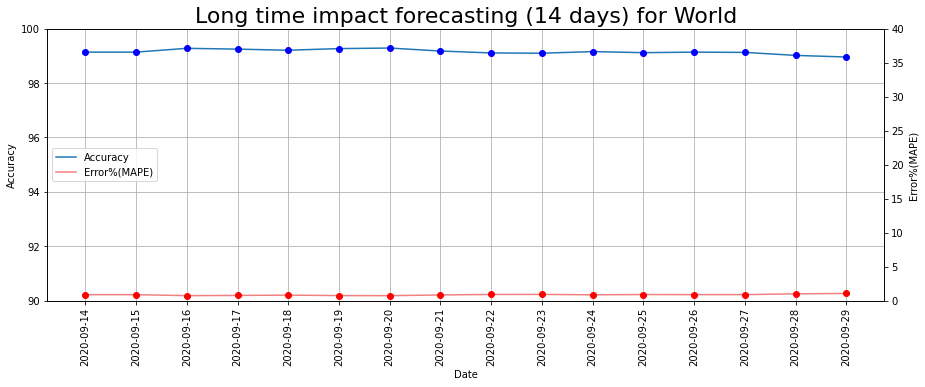

In [165]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

title="Long time impact forecasting (14 days) for "+location_name
plt.title(title,fontsize= 22)
ax1.grid()

ax1.set_ylim(90,100)
accuracy=ax1.plot(df_output.Date,df_output['Accuracy'],label='Accuracy')
for i in range(len(df_output)):
    ax1.plot(df_output.Date[i:i+1],df_output['Accuracy'][i:i+1],'bo')
error=ax2.plot(df_output.Date,df_output['Error%(MAPE)'],color="lightcoral",label='Error%(MAPE)')
for i in range(len(df_output)):
    ax2.plot(df_output.Date[i:i+1],df_output['Error%(MAPE)'][i:i+1],'ro')
ax2.set_ylim([0, 40])
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_xticks(df_output['Date'])

ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Date')
ax2.set_ylabel('Error%(MAPE)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=6)
plt.show()

In [16]:
df_location=df[df['location']==location_name]
df_location[:-121]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
46354,OWID_WRL,NaN,World,2019-12-31,27.0,27.0,NaN,0.0,0.0,NaN,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
46355,OWID_WRL,NaN,World,2020-01-01,27.0,0.0,NaN,0.0,0.0,NaN,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
46356,OWID_WRL,NaN,World,2020-01-02,27.0,0.0,NaN,0.0,0.0,NaN,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
46357,OWID_WRL,NaN,World,2020-01-03,44.0,17.0,NaN,0.0,0.0,NaN,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
46358,OWID_WRL,NaN,World,2020-01-04,44.0,0.0,NaN,0.0,0.0,NaN,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46502,OWID_WRL,NaN,World,2020-05-27,5540895.0,93781.0,98959.000,349594.0,3871.0,3859.571,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
46503,OWID_WRL,NaN,World,2020-05-28,5643714.0,102819.0,98886.429,354737.0,5143.0,3920.143,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
46504,OWID_WRL,NaN,World,2020-05-29,5762220.0,118506.0,100418.714,359379.0,4642.0,3813.286,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
46505,OWID_WRL,NaN,World,2020-05-30,5884289.0,122069.0,102742.857,364032.0,4653.0,3814.286,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
